In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 4
num_attr_vals = 3
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 81 unqiue cards
Generated 3240 cardpairs
-- 2592 cardpairs with shared concept
-- 648 cardpairs without shared concept
[(1, 1296), (2, 972), (0, 648), (3, 324)]
Total number of matches =  97200
Number of shared concepts per match =  [(1, 81648), (2, 14580), (3, 972)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1.0000000000000003e-100, 165240), (1.0288065843621402e-05, 97200)]

In [5]:
np.sum(count_table)

97200.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 65
xy_div_xyind_rank= 65


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

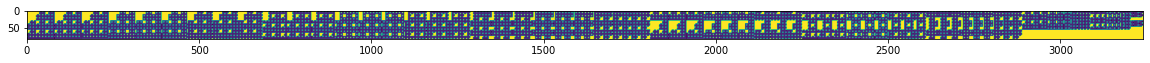

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

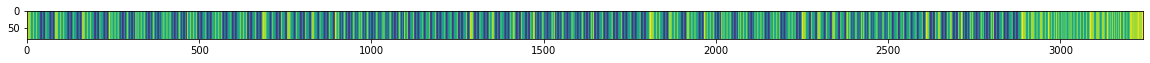

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

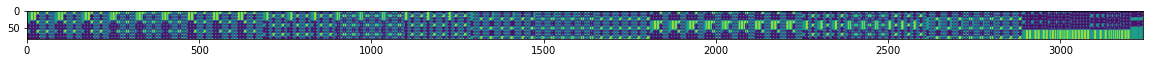

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

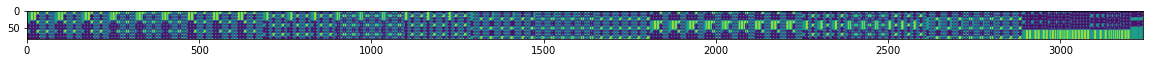

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(2.9159999999999973e-95, 64800),
 (0.9999999999999992, 48600),
 (1.7999999999999978, 40500),
 (2.999999999999997, 32400),
 (1.749599999999998e-95, 32400),
 (1.421052631578947, 17100),
 (1.3812631578947364e-95, 7200),
 (2.915999999999997e-95, 5184),
 (0.9999999999999991, 3888),
 (1.7999999999999976, 3240),
 (2.9999999999999964, 2592),
 (1.7495999999999976e-95, 2592),
 (1.4210526315789467, 1368),
 (1.3812631578947363e-95, 576)]

## Dataset

In [13]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square', 'OOO') ('red', 'dashed', 'square', 'OXO')
key
 0 ('red', 'void', 'square', 'OOO')
all matches 
 [('red', 'void', 'square', 'OOO'), ('red', 'void', 'square', 'OOX'), ('red', 'void', 'square', 'OXO'), ('red', 'void', 'circle', 'OOO'), ('red', 'void', 'circle', 'OOX'), ('red', 'void', 'circle', 'OXO'), ('red', 'void', 'triangle', 'OOO'), ('red', 'void', 'triangle', 'OOX'), ('red', 'void', 'triangle', 'OXO'), ('red', 'dashed', 'square', 'OOO'), ('red', 'dashed', 'square', 'OOX'), ('red', 'dashed', 'square', 'OXO'), ('red', 'dashed', 'circle', 'OOO'), ('red', 'dashed', 'circle', 'OOX'), ('red', 'dashed', 'circle', 'OXO'), ('red', 'dashed', 'triangle', 'OOO'), ('red', 'dashed', 'triangle', 'OOX'), ('red', 'dashed', 'triangle', 'OXO'), ('red', 'solid', 'square', 'OOO'), ('red', 'solid', 'square', 'OOX'), ('red', 'solid', 'square', 'OXO'), ('red', 'solid', 'circle', 'OOO'), ('red', 'solid', 'circle', 'OOX'), ('red', 'solid', 'circle', 'OXO'), ('red', 

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [14]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square', 'OOO') ('red', 'dashed', 'square', 'OXO')
all matches 
 [('red', 'void', 'square', 'OOO'), ('red', 'void', 'square', 'OOX'), ('red', 'void', 'square', 'OXO'), ('red', 'void', 'circle', 'OOO'), ('red', 'void', 'circle', 'OOX'), ('red', 'void', 'circle', 'OXO'), ('red', 'void', 'triangle', 'OOO'), ('red', 'void', 'triangle', 'OOX'), ('red', 'void', 'triangle', 'OXO'), ('red', 'dashed', 'square', 'OOO'), ('red', 'dashed', 'square', 'OOX'), ('red', 'dashed', 'square', 'OXO'), ('red', 'dashed', 'circle', 'OOO'), ('red', 'dashed', 'circle', 'OOX'), ('red', 'dashed', 'circle', 'OXO'), ('red', 'dashed', 'triangle', 'OOO'), ('red', 'dashed', 'triangle', 'OOX'), ('red', 'dashed', 'triangle', 'OXO'), ('red', 'solid', 'square', 'OOO'), ('red', 'solid', 'square', 'OOX'), ('red', 'solid', 'square', 'OXO'), ('red', 'solid', 'circle', 'OOO'), ('red', 'solid', 'circle', 'OOX'), ('red', 'solid', 'circle', 'OXO'), ('red', 'solid', 'triangle', 'OOO'), ('red', 'so

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [15]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [18]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            raise ValueError('Not supposed to use classifier!')
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [19]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [20]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [21]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [22]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 16,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;dot-product'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 53.1 K
1  | model.inp_query_layer                        | Sequential         | 51.8 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 51.8 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 51.8 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 1.3 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 1.3 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 1.3 K 
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [23]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=20000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr4-val3;epsilon1e-100;d_model16;params53.14K;dot-product exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-23-5f996647734c>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 2099632 bytes
wandb: WARNING Serializing object of type ndarray that is 2099632 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 53.1 K
1  | model.inp_query_layer                        | Sequential         | 51.8 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 51.8 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 51.8 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 1.3 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 1.3 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 1.3 K 
8  | loss_criterion                              

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=647, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=648, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=650, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=647, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=648, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=649, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=649, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=649, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=649, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=649, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10:  50%|█████     | 

Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=648, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=648, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=648, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=647, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=647, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=647, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=646, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=646, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=645, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|████

Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=642, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=642, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=643, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=642, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=642, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=641, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=640, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=640, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=640, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 77:  50%|████

Epoch 102:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=639, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 103:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=639, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 104:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=639, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 105:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=639, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 106:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=640, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 107:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=640, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 108:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=640, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 109:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=640, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 110:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=640, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 111:

Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=636, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=636, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=636, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 139:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=635, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 140:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=635, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 141:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=635, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 142:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=635, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 143:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=634, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 144:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=634, v_num=3crf]
Validating

Epoch 169:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=635, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 170:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=634, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 171:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=634, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 172:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=634, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=634, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=633, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 175:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=633, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 176:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=632, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 177:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=632, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 178:

Epoch 202:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=632, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 203:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=632, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 204:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=632, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 205:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=631, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 206:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=631, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 207:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=632, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 208:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=632, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 209:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=632, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 210:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=632, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 211:

Epoch 236:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 237:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=631, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 238:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 239:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=631, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 240:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=631, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 241:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 242:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 243:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 244:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=629, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 245:

Validating: 0it [00:00, ?it/s]
Epoch 270:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 271:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 272:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 273:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 274:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 275:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=630, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 276:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=629, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 277:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=629, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 278:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=629, v_num=3crf]
Validating

Epoch 303:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=627, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=627, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 305:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=627, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 306:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=626, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 307:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=626, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 308:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=626, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 309:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=626, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 310:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=626, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 311:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=626, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 312:

Epoch 336:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=628, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 337:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=628, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 338:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=628, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 339:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=628, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 340:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=628, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 341:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=627, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 342:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=628, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=628, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 344:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=628, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 345:

Validating: 0it [00:00, ?it/s]
Epoch 370:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=625, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 371: 100%|██████████| 2/2 [00:00<00:00,  7.89it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 372:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 373:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 374:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 375:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 376:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 377:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 378:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=623, v_num=3crf]
Validating

Epoch 403:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=625, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 404:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=625, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 405:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=625, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 406:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=625, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 407:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 408:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 409:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 410:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 411:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 412:

Epoch 437:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 438:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 439:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 440:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 441:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 442:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 443:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 444:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 445:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 446:

Epoch 470:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 477:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 478:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 479:

Validating: 0it [00:00, ?it/s]
Epoch 504:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 505:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=622, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 506:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=622, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 507:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=622, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 508:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=622, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 509:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=622, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 510:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=622, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 511:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=622, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 512:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=622, v_num=3crf]
Validating

Epoch 537:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 538:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 539:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 540:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 541:  50%|█████     | 1/2 [00:00<00:00,  8.89it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 542:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=624, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 543:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 544:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 545:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=623, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 546:

Epoch 571:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=622, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 572:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=622, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 573:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 574:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 575:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=622, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 576:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 577:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 578:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 579:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 580:

Validating: 0it [00:00, ?it/s]
Epoch 605:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 606:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 607:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 608:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 609:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 610:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 611:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 612:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 613:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=620, v_num=3crf]
Validating

Epoch 638:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 639:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 640:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 641:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 644:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 645:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 646:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 647:

Validating: 0it [00:00, ?it/s]
Epoch 672:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 673:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 674:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 675:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 677:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 678:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 679:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 680:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=620, v_num=3crf]
Validating

Epoch 705:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 706:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 707:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 708:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=621, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 709:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 710:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 711:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 712:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 713:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=620, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 714:

Validating: 0it [00:00, ?it/s]
Epoch 739:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=618, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 740:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=618, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=618, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=619, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=618, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 744:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=618, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 745:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=618, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 746:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=618, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 747:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=618, v_num=3crf]
Validating

Epoch 772:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=619, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 773:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=619, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=619, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 775:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=619, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 776:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=619, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 777:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=619, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 778:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=619, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 779:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=619, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 780:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=619, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 781:

Epoch 806:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=615, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=615, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 810:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=615, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 811:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=615, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 812:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 813:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=615, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 814:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 815:

Epoch 839:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=617, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 840:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=617, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 841:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=617, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 842:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=617, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 843:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=617, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 844:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=617, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 845:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=617, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 846:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=617, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 847:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=617, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 848:

Validating: 0it [00:00, ?it/s]
Epoch 873:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 874:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 875:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 876:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 877:  50%|█████     | 1/2 [00:00<00:00,  9.09it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 878:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 879:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 880:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 881:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=616, v_num=3crf]
Validating

Epoch 906:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 907:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 908:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 909:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=615, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 910:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 911:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 912:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 913:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 914:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=616, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 915:

Epoch 940:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=614, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=614, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=614, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=614, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 944:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=614, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 945:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=614, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 946:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=614, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 947:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=614, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 948:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=615, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 949:

Validating: 0it [00:00, ?it/s]
Epoch 974:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=613, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 975:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=613, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 976:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=613, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 977:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=613, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 978:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=613, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 979:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=613, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 980:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=613, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 981:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=613, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 982:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=613, v_num=3crf]
Validating

Epoch 1007:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1008:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1009:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1010:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1011:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1012:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1013:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1014:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1015:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=613, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1040:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=611, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1041:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1042:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1043:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1044:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1045:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1046:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=612, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1047:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=611, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1048:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=611, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1074:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=611, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1075:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=611, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1076:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=611, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1077:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=611, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1078:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=611, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1079:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=611, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1080:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=611, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1081:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=610, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1082:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=610, v_num=3crf]
V

Epoch 1107:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=610, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1108:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=610, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1109:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=610, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1110:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=610, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1111:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=609, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1112:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=609, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1113:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=609, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1114:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=609, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1115:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=610, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1140:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=608, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1141:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=608, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1142:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=608, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1143:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=608, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1144:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=608, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1145:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=608, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1146:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=608, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1147:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=608, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1148:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=608, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1174:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1175:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1176:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=606, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1177:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1178:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=606, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1179:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=606, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1180:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1181:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1182:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1207:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1208:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1209:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1210:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=606, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1211:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=606, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1212:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=606, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1213:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1214:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1215:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=607, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1240:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=605, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1241:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=605, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1242:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=605, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1243:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=605, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1244:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=605, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1245:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=605, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1246:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=605, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1247:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=604, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1248:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=604, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1274:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=602, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1275:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1276:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1277:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1278:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1279:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1280:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=602, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1281:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=602, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1282:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=602, v_num=3crf]
V

Epoch 1307:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1308:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1309:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=604, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1310:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1311:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=604, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1312:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1313:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1314:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1315:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=603, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1340:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=601, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1341:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=601, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1342:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=601, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1343:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=601, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1344:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=600, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1345:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=600, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1346:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=600, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1347:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=600, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1348:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=600, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1374:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=600, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1375:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=600, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1376:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=600, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1377:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=600, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1378:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=599, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1379:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=599, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1380:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=599, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1381:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=599, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1382:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=599, v_num=3crf]
V

Epoch 1407:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=597, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1408:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=597, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1409:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=598, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1410:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=598, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1411:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=598, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1412:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=597, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1413:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=598, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1414:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=597, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1415:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=597, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1440:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=597, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1441:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=597, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1442:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=597, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1443:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=596, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1444:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=597, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1445:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=597, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1446:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=596, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1447:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=596, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1448:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=596, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1473:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=595, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1474:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=595, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1475:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=595, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1476:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=595, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1477:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=595, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1478:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=596, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1479:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=595, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1480:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=596, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1481:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=595, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1506:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=594, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1507:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=594, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1508:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=594, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1509:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=594, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1510:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=594, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1511:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=594, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1512:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=594, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1513:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=594, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1514:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=594, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1540:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=593, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1541:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=593, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1542:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=593, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1543:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=593, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1544:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=593, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1545:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=593, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1546:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=593, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1547:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=593, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1548:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=593, v_num=3crf]
V

Epoch 1573:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1574:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1575:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1576:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1577:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1578:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1579:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1580:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1581:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1606:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1607:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=590, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1608:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=590, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1609:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1610:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=590, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1611:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=590, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1612:  50%|█████     | 1/2 [00:00<00:00,  8.78it/s, loss=590, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1613:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1614:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=590, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1639:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=587, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1640:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=587, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1641:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=588, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1642:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=587, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1643:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=587, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1644:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=586, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1645:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=586, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1646:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=586, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1647:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=586, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1672:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=590, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1673:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=590, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1674:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=590, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1675:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=590, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1676:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1677:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1678:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1679:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1680:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=589, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1706:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=585, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1707:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1708:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1709:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1710:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1711:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1712:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1713:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1714:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1739:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1740:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=585, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1741:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1742:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1743:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1744:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1745:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1746:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1747:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1772:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=585, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1773:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=585, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1774:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=585, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1775:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=585, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1776:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=585, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1777:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=585, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1778:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=585, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1779:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=586, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1780:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=585, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1806:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1807:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1808:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1809:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1810:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1811:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=582, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1812:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1813:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1814:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1839:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1840:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1841:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1842:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1843:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1844:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=583, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1845:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1846:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1847:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=584, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1872:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=581, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1873:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=581, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1874:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=581, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1875:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=581, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1876:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=581, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1877:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=582, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1878:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=581, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1879:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=581, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1880:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=582, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1906:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1907:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1908:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1909:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1910:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1911:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1912:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=578, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1913:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=578, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1914:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=578, v_num=3crf]
V

Epoch 1939:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1940:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=578, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1941:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=578, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1942:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=578, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1943:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=578, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1944:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=578, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1945:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1946:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1947:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1972:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=580, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1973:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=580, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1974:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=580, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1975:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=580, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1976:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1977:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1978:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1979:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 1980:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=579, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2005:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2006:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2007:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2008:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2009:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2010:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=578, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2011:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=578, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2012:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2013:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2039:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2040:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2041:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2042:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2043:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2044:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2045:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2046:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2047:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2072:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2073:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2074:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2075:  50%|█████     | 1/2 [00:00<00:00,  8.92it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2076:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2077:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2078:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2079:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2080:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2107:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2108:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2109:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2110:  50%|█████     | 1/2 [00:00<00:00,  9.20it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2111:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2112:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2113:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2114:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2115:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=573, v_num=3crf]
V

Epoch 2140:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2141:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2142:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2143:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2144:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2145:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2146:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2147:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2148:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2174:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2175:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2176:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2177:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2178:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2179:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2180:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2181:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=574, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2182:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=574, v_num=3crf]
V

Epoch 2207:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2208:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2209:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2210:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2211:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2212:  50%|█████     | 1/2 [00:00<00:00,  8.87it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2213:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2214:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2215:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2241:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2242:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2243:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2244:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2245:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2246:  50%|█████     | 1/2 [00:00<00:00,  8.89it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2247:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2248:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2249: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2276:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2277:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2278:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2279:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2280:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2281:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2282:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2283:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2284:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=573, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2311:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2312:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2313:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2314:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2315:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2316:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2317:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2318:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2319:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=569, v_num=3crf]
V

Epoch 2345:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2346:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2347:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2348:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2349: 100%|██████████| 2/2 [00:00<00:00,  7.37it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2350:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2351:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2352:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2353:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2379:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2380:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2381:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2382:  50%|█████     | 1/2 [00:00<00:00,  9.04it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2383:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2384:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2385:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2386:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2387:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2414:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2415:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2416:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2417:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2418:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2419:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=575, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2420:  50%|█████     | 1/2 [00:00<00:00,  8.92it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2421:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=577, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2422:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=576, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2449: 100%|██████████| 2/2 [00:00<00:00,  8.68it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2450:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2451:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2452:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2453:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=572, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2454:  50%|█████     | 1/2 [00:00<00:00,  8.96it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=570, v_num=3crf]
V

Epoch 2483:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2484:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2485:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2486:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2487:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2488:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2489:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2490:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2491:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2518:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2519:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2520:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2521:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2522:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2523:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2524:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2525:  50%|█████     | 1/2 [00:00<00:00,  9.22it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2526:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2551:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2552:  50%|█████     | 1/2 [00:00<00:00,  8.95it/s, loss=571, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2553:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2554:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2555:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2556:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2557:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2558:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2559:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2585:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2586:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2587:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2588:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2589:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2590:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2591:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2592:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2593:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2618:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2619:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2620:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2621:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2622:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2623:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2624:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2625:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2626:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2652:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2653:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2654:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2655:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2656:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2657:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2658:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2659:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2660:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2685:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2686:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2687:  50%|█████     | 1/2 [00:00<00:00,  8.95it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2688:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2689:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2690:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2691:  50%|█████     | 1/2 [00:00<00:00,  9.05it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2692:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2693:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2719:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2720:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2721:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=570, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2722:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2723:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2724:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2725:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2726:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2727:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2753:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2754:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2755:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2756:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2757:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2758:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2759: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2760:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2761:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2786:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2792:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2793:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2794:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2820:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2821:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2822:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2823:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2824:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2825:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2826:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2827:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2828:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2854:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2855:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2856:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2857:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2858:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2859:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2860:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2861:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2862:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2887:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2888:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2889:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2890:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=569, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2891:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2892:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2893:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2894:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2895:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2922:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2923:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2924:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2925:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2926:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2927:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2928:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2929:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2930:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2957:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2958: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2959:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2960:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2961:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2962:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2963:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2964:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2965:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2990:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2991:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2992:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2993:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2994:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2995:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2996:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2997:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 2998:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3024:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3025:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3026:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3027:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3028:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3029:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3030:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3031:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3032:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3057:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3058:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3059:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3060:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3061:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3062:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3063:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3064:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3065:  50%|█████     | 1/2 [00:00<00:00,  9.11it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3092:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3093:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3094:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3095:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3096:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3097:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3098:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3099: 100%|██████████| 2/2 [00:00<00:00,  8.47it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3100:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3126:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3127:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3128:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3129:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3130:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3131:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3132:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3133:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3134:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3159:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3160:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3161:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3162:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3163:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3164:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3165:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3166:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3167:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3193:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3194:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3195:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3196:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3197:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3198:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3199: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s, loss=568, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3200:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3201:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=568, v_num=3crf]
V

Epoch 3226:  50%|█████     | 1/2 [00:00<00:00,  8.95it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3227:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3228:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3229:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3230:  50%|█████     | 1/2 [00:00<00:00,  9.05it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3231:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3232:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3233:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3234:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3260:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3261:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3262:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3263:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3264:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3265:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3266:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3267:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3268:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3294:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3295:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3296:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3297:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3298:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3299: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3300:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3301:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3302:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3328:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3329:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3330:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3331:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3332:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3333:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3334:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3335:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3336:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3361:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3362:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3363:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3364:  50%|█████     | 1/2 [00:00<00:00,  9.16it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3365:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3366:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3367:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3368:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3369:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3395:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3396:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3397:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3398:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3399: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3400:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3401: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3402:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3403:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3428:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3429:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3430:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3431:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3432:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3433:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3434:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3435:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3436:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3462:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3463:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3464:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3465:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3466:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3467:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3468:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3469:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3470:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3496:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3497:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3498:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3499: 100%|██████████| 2/2 [00:00<00:00,  7.50it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3500:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3501:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3502:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3503:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3504:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3529:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3530:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3531:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3532:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3533:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3534:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3535:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3536:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3537:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3563:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3564:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3565:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3566:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3567:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3568:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3569:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3570:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3571:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3596:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3597:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3598:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3599: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3600:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3601:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3602:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3603:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3604:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3629:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3630:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3631:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3632:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3633:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3634:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3635:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3636:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3637:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3662:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3663:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3664:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3665:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3666:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3667:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3668:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=567, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3669: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3670:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3697:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3698:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3699:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3700:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3701:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3702:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3703:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3704:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3705: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s, loss=563, v_num=3crf]
V

Epoch 3730:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3731:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3732:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3733:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3734:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3735:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3736:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3737:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3738:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3763:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3764:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3765:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3766:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3767:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3768:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3769:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3770:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3771:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3797:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3798:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3799:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3800:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3801:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3802:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3803:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3804:  50%|█████     | 1/2 [00:00<00:00,  9.09it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3805:  50%|█████     | 1/2 [00:00<00:00,  8.91it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3830:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3831:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3832:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3833:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3834:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3835:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3836:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3837:  50%|█████     | 1/2 [00:00<00:00,  8.78it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3838:  50%|█████     | 1/2 [00:01<00:01,  1.42s/it, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3865:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3866:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3867:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3868:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3869:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3870:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3871:  50%|█████     | 1/2 [00:00<00:00,  8.85it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3872:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3873:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3898:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3899:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3900:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3901:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3902:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3903:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3904:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3905:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3906:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3932:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3933:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3934:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3935:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3936:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3937:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3938:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3939:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3940:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3966:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3967:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3968:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3969:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3970:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3971:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3972:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3973:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 3974:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4000:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4001:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4002:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4003:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4004:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4005:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4006:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4007:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4008:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4034:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4035:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4036:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4037:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4038:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4039:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4040:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4041:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4042:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4068:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4069:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4070:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4071:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4072:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4073:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4074:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4075:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4076:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4101:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4102:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4103:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4104:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4105:  50%|█████     | 1/2 [00:00<00:00,  8.92it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4106:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4107:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4108:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4109:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4135:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4136:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4137:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4138:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4139:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4140:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4141:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4142:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4143:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 4170:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4171:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4172:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4178:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=563, v_num=3crf]
V

Epoch 4204:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4205:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4206:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4207:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4208:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4209:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4210:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4211:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4212:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4238:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4239:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4240:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4241:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4242:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4243:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4244:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4245:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4246:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4272:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4273:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4274:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4275:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4276:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4277:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4278:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4279:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4280:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4306:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4307:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4308:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4309:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4310:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4311:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4312:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4313:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4314:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4339:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4340: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4341:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4342:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4343:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4344:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4345:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4346:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4347:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4373:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4374:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4375:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4376:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4377:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4378:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4379:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4380:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4381:  50%|█████     | 1/2 [00:00<00:00,  8.87it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4406:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4407:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4408:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4409:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4410:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4411:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4412:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4413:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4414:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4440:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4441:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4442:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4443:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4444:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4445:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4446:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4447:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4448:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4473:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4474:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4475:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4476:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4477:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4478:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4479:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4480:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4481:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4507:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4508:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4509:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4510:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4511:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4512:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4513:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4514:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4515:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4540:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4541:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4542:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4543:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4544:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4545:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4546:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4547:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4548:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4573:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4574:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4575:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4576:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4577:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4578:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4579:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4580:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4581:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4607:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4608:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4609:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4610:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4611:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4612:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4613:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4614:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4615:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4640:  50%|█████     | 1/2 [00:00<00:00,  9.02it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4641:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4642:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4643:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4644:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4645:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4646:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4647:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4648:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4674:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4675:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4676:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4677:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4678:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4679:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4680:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4681:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4682:  50%|█████     | 1/2 [00:00<00:00,  8.87it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4708:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4709:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4710:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4711:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4712:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4713:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4714:  50%|█████     | 1/2 [00:00<00:00,  9.01it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4715:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4716:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4742:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4743:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4744:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4745:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4746:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4747:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4748:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4749:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4750:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4776:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4777:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4778:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4779:  50%|█████     | 1/2 [00:00<00:00,  9.32it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4780:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4781:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4782:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4783:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4784:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4810:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4811:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4812:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4813:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4814:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4815:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4816:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4817:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4818:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4843:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4844:  50%|█████     | 1/2 [00:00<00:00,  8.99it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4845:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4846:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4847:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4848:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4849:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4850:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4851:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4877:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4878:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4879:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4880:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4881:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4882:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4883:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4884:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4885:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4911:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4912:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4913: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4914:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4915:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4916:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4917:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4918:  50%|█████     | 1/2 [00:00<00:00,  8.96it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4919:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4945:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4946:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4947:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4948: 100%|██████████| 2/2 [00:00<00:00,  7.51it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4949:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4950:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4951:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4952:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4953:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4979:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4980:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4981:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4982:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4983:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4984:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4985:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4986:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 4987:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5012:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5013:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5014:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5015:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5016:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5017:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5018:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5019:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5020:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5046:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5047:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5048:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5049:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5050:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5051:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5052:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5053:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5054:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5079:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5080:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5081:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5082:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5083:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5084:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5085:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5086:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5087:  50%|█████     | 1/2 [00:00<00:00,  8.78it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5112:  50%|█████     | 1/2 [00:00<00:00,  8.90it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5113:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5114:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5115:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5116:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5117:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5118:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5119:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5120:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 5146:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5147:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5148:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5149: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5150:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5151:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5152:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5153:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5154:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=562, v_num=3crf]
V

Epoch 5179:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5180:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5181:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5182:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5183:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5184:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5185:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5186:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5187:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5212:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5213:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5214:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5215:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5216:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5217:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5218:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5219:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5220:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5246:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5247:  50%|█████     | 1/2 [00:00<00:00,  9.08it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5248:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5249:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5250:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5251:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5252:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5253:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5254:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5280:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5281:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5282:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5283:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5284:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5285:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5286:  50%|█████     | 1/2 [00:00<00:00,  9.15it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5287:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5288:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5313:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5314:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5315:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5316:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5317:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5318:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5319:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5320:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5321:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5347:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5348:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5349:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5350:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5351:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5352:  50%|█████     | 1/2 [00:00<00:00,  9.04it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5353:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5354:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5355:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5380:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5381:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5382:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5383:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5384:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5385:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5386:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5387:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5388:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5413:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5414:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5415:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5416:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5417:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5418:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5419:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5420:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5421:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5446:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5447:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5448:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5449:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5450:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5451:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5452:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5453:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5454:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5480:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5481:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5482:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5483:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5484:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5485:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5486:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5487:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5488:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5513:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5514:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5515:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5516:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5517:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5518:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5519:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5520:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5521:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5546:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5547:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5548:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5549: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5550:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5551:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5552:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5553:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5554:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 5580:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5581:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5582:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5583:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5584:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5585:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5586:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5587:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5588:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=561, v_num=3crf]
V

Epoch 5613:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5614:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5615:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5616:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5617:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5618:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5619:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5620:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5621:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5647:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5648:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5649:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5650:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5651: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5652:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5653:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5654:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5655:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5681:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5682:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5683:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5684:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5685:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5686:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5687:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5688:  50%|█████     | 1/2 [00:00<00:00,  8.97it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5689:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5715:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5716:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5717:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5718:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5719:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5720:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5721:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5722:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5723:  50%|█████     | 1/2 [00:00<00:00,  8.92it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5748:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5749:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5750:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5751:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5752:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5753:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5754:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5755:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5756:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5782:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5783:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5784:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5785:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5786:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5787:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5788:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5789:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5790:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5815:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5816:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5817:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5818:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5819:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5820:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5821:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5822:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5823:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5849:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5850:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5851:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5852:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5853:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5854:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5855:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5856:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5857:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5882:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5883:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5884:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5885:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5886:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5887:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5888:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5889:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5890:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5916:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5917:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5918:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5919:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5920:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5921:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5922:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5923:  50%|█████     | 1/2 [00:00<00:00,  9.11it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5924:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5950:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5951:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5952:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5953:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5954:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5955:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5956: 100%|██████████| 2/2 [00:00<00:00,  7.65it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5957:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5958:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5983:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5984:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5985:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5986:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5987:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5988:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5989:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5990:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 5991:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6016:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6017:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6018:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6019:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6020:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6021:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6022:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6023:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6024:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6051:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6052:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6053:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6054: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6055:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6056:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6057:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6058:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6059:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6084:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6085:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6086:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6087:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6088:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6089:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6090:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6091:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6092:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6117:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6118:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6119:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6120:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6121:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6122:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6123:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6124:  50%|█████     | 1/2 [00:00<00:00,  8.89it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6125:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6151:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6152:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6153:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6154:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6155:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6156:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6157:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6158:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6159:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6185:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6186:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6187:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6188:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6189:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6190:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6191:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6192:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6193:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=562, v_num=3crf]
V

Epoch 6218:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6219:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6220:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6221:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6222:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6223:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6224:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6225:  50%|█████     | 1/2 [00:00<00:00,  8.85it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6226:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6251:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6252:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6253:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6254:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6255:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6256:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6257:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6258:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6259:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6285:  50%|█████     | 1/2 [00:00<00:00,  8.92it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6286:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6287:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6288:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6289:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6290:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6291:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6292:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6293:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6319:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6320:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6321:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6322:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6323:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6324:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6325:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6326:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6327:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6353:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6354:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6355:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6356:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6357:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6358:  50%|█████     | 1/2 [00:00<00:00,  8.91it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6359:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6360:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6361:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6388:  50%|█████     | 1/2 [00:00<00:00,  9.23it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6389:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6390:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6391:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6392:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6393:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6394:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6395:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6396:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6421:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6422:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6423:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6424:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6425:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6426:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6427:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6428:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6429:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6456:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6457:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6458:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6459:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6460:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6461:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6462:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6463:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6464:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=559, v_num=3crf]
V

Epoch 6490:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6491:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6492:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6493:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6494:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6495:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6496:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6497:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6498:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6523:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6524:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6525:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6526:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6527:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6528:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6529:  50%|█████     | 1/2 [00:00<00:00,  8.98it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6530:  50%|█████     | 1/2 [00:00<00:00,  9.06it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6531:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6557:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6558:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6559:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6560:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6561:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6562:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6563:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6564:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6565:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6592:  50%|█████     | 1/2 [00:00<00:00,  8.88it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6593:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6594:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6595:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6596:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6597:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6598:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6599:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6600:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=560, v_num=3crf]
V

Epoch 6625:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6626:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6627:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6628:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6629:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6630:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6631:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6632:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6633:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6659:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=566, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6660:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6661:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6662:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6663:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6664:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6665:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6666:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6667:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6693:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6694:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6695:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6696:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6697:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6698:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6699:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6700:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6701:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6727:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6728:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6729:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6730:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6731:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6732:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6733:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6734:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6735:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6761:  50%|█████     | 1/2 [00:00<00:00,  8.92it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6762:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6763:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6764:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6765:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6766:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6767:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6768:  50%|█████     | 1/2 [00:00<00:00,  9.09it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6769:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6795:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6796:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6797:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6798:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6799:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6800:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6801:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6802:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6803:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6828:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6829:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6830:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6831:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6832:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6833:  50%|█████     | 1/2 [00:00<00:00,  9.22it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6834:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6835:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6836:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6862:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6863:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6864:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6865:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6866:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6867:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6868:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6869:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6870:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6897:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6898:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6899:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6900:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6901:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6902:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6903:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6904:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6905:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6931:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6932:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6933:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6934:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6935:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6936:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6937:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6938:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6939:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6966:  50%|█████     | 1/2 [00:00<00:00,  8.91it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6967:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6968:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6969:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6970:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6971:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6972:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6973:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 6974:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 7001:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7002:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7003:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7004:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7005:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7006:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7007:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7008:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7009:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=560, v_num=3crf]
V

Epoch 7035:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7036:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7037:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7038:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7039:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7040:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7041:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7042:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7043:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 7070:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7071:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7072:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7073:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7074:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7075:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7076:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7077:  50%|█████     | 1/2 [00:00<00:00,  9.19it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7078:  50%|█████     | 1/2 [00:00<00:00,  9.04it/s, loss=564, v_num=3crf]
V

Epoch 7104:  50%|█████     | 1/2 [00:00<00:00,  9.20it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7105:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7106:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7107:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7108:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7109:  50%|█████     | 1/2 [00:00<00:00,  9.22it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7110: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7111:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7112:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7139:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7140:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7141:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7142:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7143:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7144:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7145:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7146:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7147:  50%|█████     | 1/2 [00:00<00:00,  9.07it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7173:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7174:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7175:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7176:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7177:  50%|█████     | 1/2 [00:00<00:00,  8.88it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7178:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7179:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7180:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7181:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7207:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7208:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7209:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7210:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7211:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7212:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7213:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7214: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7215: 100%|██████████| 2/2 [00:00<00:00,  7.56it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7240:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7241:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7242:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7243:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7244:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7245:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7246:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7247:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7248:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 7274:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7275:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7276:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7277:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7278:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7279:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7280:  50%|█████     | 1/2 [00:00<00:00,  8.80it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7281:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7282:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=563, v_num=3crf]
V

Epoch 7307:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7308:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7309:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7310:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7311:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7312:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7313:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7314:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7315:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 7341:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7342:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7343:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7344:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7345:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7346:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7347:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7348:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7349:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=562, v_num=3crf]
V

Epoch 7375:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7376:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7377:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7378:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7379:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7380:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7381:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7382:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7383:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7408:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7409:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7410:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7411:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7412:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7413:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7414:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7415:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7416:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7442:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7443:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7444:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7445:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7446:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7447:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7448:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7449:  50%|█████     | 1/2 [00:00<00:00,  8.89it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7450:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7476:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7477:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7478:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7479:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7480:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7481:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7482:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7483:  50%|█████     | 1/2 [00:00<00:00,  9.23it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7484:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7510:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7511:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7512:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7513:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7514:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7515:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7516:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7517:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7518:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7544:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7545:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7546:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7547:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7548:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7549:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7550:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7551:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7552:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7577:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7578:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7579:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7580:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7581:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7582:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7583:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7584:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7585:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7610:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7611:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7612:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7613:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7614:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7615:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7616:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7617:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7618:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 7644:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7645:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7646:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7647:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7648:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7649:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7650:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7651:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7652:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=559, v_num=3crf]
V

Epoch 7678:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7679:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7680:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7681:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7682:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7683:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7684:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7685:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7686:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7712:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7713:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7714:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7715:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7716:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7717:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7718:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7719:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7720:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7746:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7747:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7748:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7749:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7750:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7751:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7752:  50%|█████     | 1/2 [00:00<00:00,  9.16it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7753:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7754:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7779:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7780:  50%|█████     | 1/2 [00:00<00:00,  9.25it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7781:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7782:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7783:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7784:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7785:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7786:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7787:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7813:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7814:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7815:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7816:  50%|█████     | 1/2 [00:00<00:00,  8.99it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7817:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7818:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7819:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7820:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7821:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7847:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7848:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7849:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7850:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7851:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7852:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7853:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7854:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7855:  50%|█████     | 1/2 [00:00<00:00,  9.22it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7881:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7882:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7883:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7884:  50%|█████     | 1/2 [00:00<00:00,  8.95it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7885:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7886:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7887:  50%|█████     | 1/2 [00:00<00:00,  8.89it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7888:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7889:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7914:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7915:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7916:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7917:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7918:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7919:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7920:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7921:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7922:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7948:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7949:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7950:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7951:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7952:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7953:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7954:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7955:  50%|█████     | 1/2 [00:00<00:00,  8.90it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7956:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7981:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7982:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7983:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7984:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7985:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7986:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7987:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7988:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 7989:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8016:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8017:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8018:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8019:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8020:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8021:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8022:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8023:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=565, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8024:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=564, v_num=3crf]
V

Epoch 8049:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8050:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8051:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8052:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8053:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8054:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8055:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8056:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8057:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8083:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8084:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8085:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8086:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8087:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8088:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8089:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8090:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8091:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8116:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8117:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8118:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8119:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8120:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8121:  50%|█████     | 1/2 [00:00<00:00,  9.02it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8122:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8123:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8124:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8150:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8151:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8152:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8153:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8154:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8155:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8156:  50%|█████     | 1/2 [00:00<00:00,  8.97it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8157:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8158:  50%|█████     | 1/2 [00:00<00:00,  9.00it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8184:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8185:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8186:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8187:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8188:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8189:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8190:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8191:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8192:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8218:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8219:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8220:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8221:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8222:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8223:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8224:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8225:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8226:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8251:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8252:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8253:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8254:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8255:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8256:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8257:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8258:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8259:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8285:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8286:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8287:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8288:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8289:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8290:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8291:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8292:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8293:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8318:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8319:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8320:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8321:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8322:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8323:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8324:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8325:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8326:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8352:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8353:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8354:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8355:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8356:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8357:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8358:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8359:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8360:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=558, v_num=3crf]
V

Epoch 8385:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8386:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8387:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8388:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8389:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8390:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8391:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8392:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8393:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8418:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8419:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8420:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8421:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8422:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8423:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8424:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8425:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8426:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8452:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8453:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8454:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8455:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8456:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8457:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8458:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8459:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8460:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8486:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8487:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8488:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8489:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8490:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8491:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8492:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8493:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8494:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=561, v_num=3crf]
V

Epoch 8519:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8520:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8521:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8522:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8523:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8524:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8525:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8526:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8527:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8552:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8553:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8554:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8555:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8556:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8557:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8558:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8559:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8560:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8585:  50%|█████     | 1/2 [00:00<00:00,  8.80it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8586:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8587:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8588:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8589:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8590:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8591:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8592:  50%|█████     | 1/2 [00:00<00:00,  8.78it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8593:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8619:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8620:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8621:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8622:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8623:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8624:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8625:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8626:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8627:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8653:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8654:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8655:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8656:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8657:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8658:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8659:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8660:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8661:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=562, v_num=3crf]
V

Validating: 0it [00:00, ?it/s]
Epoch 8687:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8688:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8689:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8690:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8691:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8692:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8693:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8694:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8695:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=563, v_num=3crf]
V

Epoch 8720:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8721:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8722:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8723:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8724:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8725:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8726:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8727:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8728:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8754:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8755:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8756:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8757:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8758:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8759:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8760:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8761:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8762:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8787:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8788:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8789:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8790:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8791:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8792:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8793:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8794:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8795:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8821:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8822:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8823:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8824:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8825:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8826:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8827:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8828:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8829:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8854:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8855:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8856:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8857:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8858:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8859:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8860:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8861:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8862:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8888:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=564, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8889:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8890:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=563, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8891:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8892:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8893:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8894:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8895:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8896:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8922:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8923:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8924:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8925:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8926:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8927:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8928:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8929:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8930:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8955:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8956:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8957:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8958:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8959:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8960:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8961:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8962:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8963:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8989:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8990:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8991:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8992:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8993:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8994:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8995:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8996:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 8997:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9022:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9023:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9024:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9025:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9026:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9027:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9028:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9029:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9030:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9056:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9057:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9058:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9059:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9060:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9061:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9062:  50%|█████     | 1/2 [00:00<00:00,  9.14it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9063:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9064:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9089:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9090:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9091:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9092:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9093:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9094:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9095:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9096:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9097:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9122:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9123:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9124:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9125:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9126:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9127:  50%|█████     | 1/2 [00:00<00:00,  8.98it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9128:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9129:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9130:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9156:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9157:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9158:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9159:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9160:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9161:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9162:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9163:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9164:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9190:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9191:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9192:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9193:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9194:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9195:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9196:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9197:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9198:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9223:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9224:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9225:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9226:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9227:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9228:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9229:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9230:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9231:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9257:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9258:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9259:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9260:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9261:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9262:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9263:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9264:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9265:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9290:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9291:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9292:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9293:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9294:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9295:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9296:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9297:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9298:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9323:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9324:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9325:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9326:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9327:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9328:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9329:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9330:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9331:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9357:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9358:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9359:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9360:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9361:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9362:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9363:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9364:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9365:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=560, v_num=3crf]
V

Epoch 9390:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9391:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9392:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9393:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9394:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9395:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9396:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9397:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9398:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9423:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9424:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9425:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9426:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9427:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9428:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9429:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9430:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9431:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9457:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9458:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9459:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9460:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9461:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9462:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9463:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9464:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9465:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=558, v_num=3crf]
V

Epoch 9490:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9491:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9492:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9493:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9494:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9495:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9496:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9497:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9498:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9524:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9525:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9526:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9527:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9528:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9529:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9530:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9531:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9532:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9557:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9558:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9559:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9560:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9561:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9562:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9563:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9564:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9565:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9590:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9591:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9592:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9593:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9594:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9595:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9596:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9597:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9598:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9625:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9626:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9627:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9628:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9629:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9630:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9631:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9632:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9633:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=560, v_num=3crf]
V

Epoch 9658:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9659:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9660:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9661:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9662:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9663:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9664:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9665:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9666:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9691:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9692:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9693:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9694:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9695:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9696:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9697:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9698:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9699:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=562, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9725:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9726:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9727:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9728:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9729:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9730:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9731:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9732:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9733:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=558, v_num=3crf]
V

Epoch 9758:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9759:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9760:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9761:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9762:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9763:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9764:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9765:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9766:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9791:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9792:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9793:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9794:  50%|█████     | 1/2 [00:00<00:00,  8.80it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9795:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9796:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9797:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9798:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9799:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9824:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9825:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9826:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9827:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9828:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9829:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9830:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9831:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9832:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9858:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9859:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9860:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9861:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9862:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9863:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9864:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9865:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9866:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=557, v_num=3crf]
V

Epoch 9891:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9892:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9893:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9894:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9895:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9896:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9897:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9898:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9899:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9925:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9926:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9927:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9928:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9929:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9930:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9931:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9932: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9933:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9958:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9959:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9960:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9961:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9962:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9963:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9964:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9965: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9966:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9991:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9992:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9993: 100%|██████████| 2/2 [00:00<00:00,  4.60it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9994:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9995:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9996:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9997:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9998:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 9999:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
E

Epoch 10024:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10025:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10026:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10027:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10028:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10029:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10030:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10031:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10032:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Epoch 10057:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10058:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10059:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10060:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10061:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10062:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10063:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10064:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10065:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=560, v_num=3crf]
Validating: 0it [00:00,

Epoch 10090:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10091:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10092:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10093:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10094:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10095:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10096:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10097:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10098:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 10123:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10124:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10125:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10126:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10127:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10128:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10129:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10130:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10131:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 10156:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10157:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10158:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10159:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10160:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10161:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10162:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10163:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10164:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10189:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10190:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10191:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10192:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10193:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10194:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10195:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10196:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10197:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=558, v_nu

Epoch 10221:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10222:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10223:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10224:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10225:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10226:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10227:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10228:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10229:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=560, v_num=3crf]
Validating: 0it [00:00,

Epoch 10254:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10255:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10256:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10257:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10258:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10259:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10260:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10261:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=561, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10262:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=561, v_num=3crf]
Validating: 0it [00:00,

Epoch 10287:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10288:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10289:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10290:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10291:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10292:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10293:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10294:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10295:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=559, v_num=3crf]
Validating: 0it [00:00,

Epoch 10320:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10321:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10322:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10323:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10324:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10325:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10326:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10327:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10328:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10354:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10355:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10356:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10357:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10358:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10359:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10360:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10361:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10362:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=560, v_nu

Epoch 10387:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10388:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10389:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10390:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10391:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10392:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10393:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10394:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10395:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 10420:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10421:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10422:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10423:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10424:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10425:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10426:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10427:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10428:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=559, v_num=3crf]
Validating: 0it [00:00,

Epoch 10453:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10454:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10455:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10456:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10457:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10458:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10459:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10460:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10461:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=560, v_num=3crf]
Validating: 0it [00:00,

Epoch 10486:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10487:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10488:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10489:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10490:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10491:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10492:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10493:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10494:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=559, v_num=3crf]
Validating: 0it [00:00,

Epoch 10519:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10520:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10521:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10522:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10523:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10524:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10525:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10526:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10527:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Epoch 10552:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10553:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10554:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10555:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10556:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10557:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10558:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10559:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10560:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Epoch 10585:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10586:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10587:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10588:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10589:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10590:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10591:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10592:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10593:  50%|█████     | 1/2 [00:00<00:00,  8.90it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Epoch 10618:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10619:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10620:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10621:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10622:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10623:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10624:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10625:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10626:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=559, v_num=3crf]
Validating: 0it [00:00,

Epoch 10651:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10652:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10653:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10654:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10655:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10656:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10657:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10658:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10659:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 10684:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10685:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10686:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10687:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10688:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10689:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10690:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10691:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10692:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=559, v_num=3crf]
Validating: 0it [00:00,

Epoch 10717:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10718:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10719:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10720:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10721:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10722:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10723:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10724:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10725: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s, loss=561, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10751:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10752:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10753:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10754:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10755:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10756:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10757:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10758:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10759:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=556, v_nu

Epoch 10783:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10784:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10785:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10786:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10787:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10788:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10789:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10790:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10791:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 10816:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10817:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10818:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10819:  50%|█████     | 1/2 [00:00<00:00,  8.78it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10820:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10821:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10822:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10823:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10824:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Epoch 10849:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10850:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10851:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10852:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10853:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10854:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10855:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10856: 100%|██████████| 2/2 [00:00<00:00,  8.25it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10857:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 10882:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10883:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10884:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10885:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10886:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10887:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10888:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10889:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10890:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 10915:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10916:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10917:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10918:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10919:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10920:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10921:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10922:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10923:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10948:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10949:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10950:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10951:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10952:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10953:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10954:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10955:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10956:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=558, v_nu

Epoch 10980:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10981:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10982:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10983:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10984:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10985:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10986:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10987:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 10988:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11014:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11015:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11016:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11017:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11018:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11019:  50%|█████     | 1/2 [00:00<00:00,  9.26it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11020:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11021:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11022:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=556, v_nu

Epoch 11047:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11048:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11049:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11050:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11051:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11052:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11053:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11054:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11055:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=559, v_num=3crf]
Validating: 0it [00:00,

Epoch 11080:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11081:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11082:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11083:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11084:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11085:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11086:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11087:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11088:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11114:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11115:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11116:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11117:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11118:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11119:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11120:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11121:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11122:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=553, v_nu

Epoch 11147:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11148:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11149:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11150:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11151:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11152:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11153:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11154:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11155:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 11180:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11181:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11182:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11183:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11184:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11185:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11186:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11187:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11188:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 11213:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11214:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11215:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11216:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11217:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11218:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11219:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11220:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11221:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 11246:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11247:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11248:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11249:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11250:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11251:  50%|█████     | 1/2 [00:00<00:00,  9.00it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11252:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11253:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11254:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 11279:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11280:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11281:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11282:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11283:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11284:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11285:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11286:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11287:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=559, v_num=3crf]
Validating: 0it [00:00,

Epoch 11312:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11313:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11314:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11315:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11316:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11317:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11318:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11319:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11320:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 11345:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11346:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11347:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11348:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11349:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11350:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11351:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11352:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11353:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 11379:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11380:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11381:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11382:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11383:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11384:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11385:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11386:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11387:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 11412:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11413:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11414:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11415:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11416:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11417:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11418:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11419:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11420:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 11445:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11446:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11447:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11448:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11449:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11450: 100%|██████████| 2/2 [00:00<00:00,  7.22it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11451:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11452:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11453:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 11478:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11479:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11480:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11481:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11482:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11483:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11484:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11485:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11486:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11512:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11513:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11514:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11515:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11516:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11517:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11518:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11519:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11520:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=556, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 11545:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11546:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11547:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11548:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11549:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11550:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11551:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11552:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11553:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=559, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 11578:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11579:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11580:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11581:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11582:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11583:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11584:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11585:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11586:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=557, v_nu

Epoch 11610:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11611:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11612:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11613:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11614:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11615:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11616:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11617:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11618:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 11643:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11644:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11645:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11646:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11647:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11648:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11649:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11650:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11651:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 11676:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11677:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11678:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11679:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11680:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11681:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11682:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11683:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11684:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 11709:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11710:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11711:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11712:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11713:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11714:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11715: 100%|██████████| 2/2 [00:00<00:00,  7.32it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11716:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11717:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11743:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11744:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11745:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11746:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11747:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11748:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11749:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11750:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11751:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=558, v_nu

Epoch 11776:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11777:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11778:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11779:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11780:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11781:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11782:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11783:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11784:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 11809:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11810:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11811:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11812:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11813:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11814:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11815:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11816:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11817:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11843:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11844:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11845:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11846:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11847: 100%|██████████| 2/2 [00:00<00:00,  7.12it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11848:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11849:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11850:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11851:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=555, v_nu

Epoch 11876:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11877:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11878:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11879:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11880:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11881:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11882:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11883:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11884:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 11909:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11910:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11911:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11912:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11913:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11914:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11915:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11916:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11917:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 11942:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11943:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11944:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11945:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11946:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11947:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11948:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11949:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11950:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11976:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11977:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11978:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11979:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11980:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11981:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11982:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11983:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 11984:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=557, v_nu

Epoch 12008:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12009:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12010:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12011:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12012:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12013:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12014:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12015:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12016:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 12042:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12043:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12044:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12045:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12046:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12047:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12048:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12049:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12050:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Epoch 12075:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12076:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12077:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12078:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12079:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12080:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12081:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12082:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12083:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12109:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12110:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12111:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12112:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12113: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12114:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12115:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12116:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12117:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=557, v_nu

Epoch 12142:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12143:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12144:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12145:  50%|█████     | 1/2 [00:00<00:00,  8.78it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12146:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12147:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12148:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12149:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12150:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Epoch 12175:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12176:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12177:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12178:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12179:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12180:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12181:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12182:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12183:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 12208:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12209:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12210:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12211:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12212:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12213:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12214:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12215:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12216:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12241:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12242:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12243:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12244:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12245:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12246:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12247:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12248:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12249:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=556, v_nu

Epoch 12273:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12274:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12275:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12276:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12277:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12278:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12279:  50%|█████     | 1/2 [00:00<00:00,  9.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12280:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12281:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 12306:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12307:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12308:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12309:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12310:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12311:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12312:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12313:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12314:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 12339:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12340:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12341:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12342:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12343:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12344:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12345:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12346:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12347:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 12372:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12373:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12374:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12375:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12376:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12377:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12378:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12379:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12380:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12406:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12407:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12408:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12409:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=560, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12410:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12411:  50%|█████     | 1/2 [00:00<00:00,  9.00it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12412:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12413:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12414:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=558, v_nu

Epoch 12439:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12440:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12441:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12442:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12443:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12444:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12445:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12446:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12447:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Epoch 12472:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12473: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12474:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12475:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12476:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12477:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12478:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12479:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12480:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 12505:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12506:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12507:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12508:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12509:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12510:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12511:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12512:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12513:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 12539:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12540:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12541:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12542:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12543:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12544:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12545:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12546:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12547:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 12572:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12573:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12574:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12575:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12576:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12577:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12578:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12579:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12580:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 12606:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12607:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12608:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12609:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12610:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12611:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12612:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12613:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12614:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 12639:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12640:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12641:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12642:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12643:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12644:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12645:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12646:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12647:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 12672:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12673:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12674:  50%|█████     | 1/2 [00:00<00:00,  8.87it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12675:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12676:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12677:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12678:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12679:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12680:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 12705:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12706:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12707:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12708:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12709:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12710:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12711:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12712:  50%|█████     | 1/2 [00:00<00:00,  8.99it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12713:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 12738: 100%|██████████| 2/2 [00:00<00:00,  8.41it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12739:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12740:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12741:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12742:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12743:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12744:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12745:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12746:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 12772:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12773:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12774:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12775:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12776:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12777:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12778:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12779:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12780:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 12805:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12806:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12807:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12808:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12809:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12810:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12811:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12812:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12813:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 12838:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12839:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12840:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12841:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12842:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12843:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12844:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12845:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12846:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12871:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12872:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12873:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12874:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12875:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12876:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12877:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12878:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12879:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=555, v_nu

Epoch 12904:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12905:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12906:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12907:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12908:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12909:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12910:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12911:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12912:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 12937:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12938:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12939:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12940:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12941:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12942:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12943:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12944:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12945:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12970:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12971:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12972:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12973:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12974:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12975:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12976:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12977:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 12978:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=552, v_nu

Epoch 13002:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13003:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13004:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13005:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13006:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13007:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13008:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13009:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13010:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13036:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13037:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13038:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13039:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13040:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13041:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13042:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13043:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13044:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=554, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 13069:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13070:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13071:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13072:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13073:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13074:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13075:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13076:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13077:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=554, v_nu

Epoch 13101:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13102:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13103:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13104:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13105:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13106:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13107:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13108:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13109:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 13134:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13135:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13136:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13137:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13138:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13139:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13140:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13141:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13142:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 13167:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13168:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13169:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13170:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13171:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13172:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13173:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13174:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13175:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 13200:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13201:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13202:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13203:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13204:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13205:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13206:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13207:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13208:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 13233:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13234:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13235:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13236:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13237:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13238:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13239:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13240:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=559, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13241:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=558, v_num=3crf]
Validating: 0it [00:00,

Epoch 13266:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13267:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13268:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13269:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13270:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13271:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13272:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13273:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13274:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 13299: 100%|██████████| 2/2 [00:00<00:00,  7.68it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13300:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13301:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13302:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13303:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13304:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13305:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13306:  50%|█████     | 1/2 [00:00<00:00,  9.00it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13307:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 13332:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13333:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13334:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13335:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13336:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13337:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13338:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13339:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13340:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 13365:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13366:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13367:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13368:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13369:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13370:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13371:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13372:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13373:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 13398:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13399:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13400:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13401:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13402:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13403:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13404:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13405:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13406:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 13431:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13432:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13433:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13434:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13435:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13436:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=558, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13437:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13438:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13439:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Epoch 13464:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13465:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13466:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13467:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13468:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13469:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13470:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13471:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13472:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13498: 100%|██████████| 2/2 [00:00<00:00,  7.65it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13499:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13500:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13501:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13502:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13503:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13504:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13505:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13506:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=555, v_nu

Epoch 13530:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13531:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13532:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13533:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13534:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13535:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13536:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13537:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13538:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13564:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13565:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13566:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13567:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13568:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13569:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13570:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13571:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13572:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=556, v_nu

Epoch 13597:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13598:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13599:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13600:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13601:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13602:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13603:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13604:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13605:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=557, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13630:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13631:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13632:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13633:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13634:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13635:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13636:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13637:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13638:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=555, v_nu

Epoch 13662:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13663:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13664:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13665:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13666:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13667:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13668:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13669:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13670:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13696:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13697:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13698:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13699:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13700:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13701:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13702:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13703:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13704:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=554, v_nu

Epoch 13728:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13729:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13730:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13731:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13732:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13733:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13734:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13735:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13736:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13762:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13763:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13764:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13765:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13766:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13767:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13768:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13769:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13770:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=554, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 13795:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13796:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13797:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13798:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13799:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13800:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13801:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13802:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13803:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=552, v_nu

Epoch 13828:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13829:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13830:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13831:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13832:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13833:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13834:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13835:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13836:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 13861:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13862:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13863:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13864:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13865:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13866:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13867:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13868:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13869:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 13894:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13895:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13896:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13897:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13898:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13899:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13900:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13901:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13902:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 13927:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13928:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13929:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13930:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13931:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13932:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13933:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13934:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13935:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 13960:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13961:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13962:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13963:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13964:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13965:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13966:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13967:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13968:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 13993:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13994:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13995:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13996:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13997:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13998:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 13999: 100%|██████████| 2/2 [00:00<00:00,  8.03it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14000:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14001:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 14026:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14027:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14028:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14029:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14030:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14031:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14032:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14033:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14034:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 14059:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14060:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14061:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14062:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14063:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14064:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14065:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14066:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14067:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 14093:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14094:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14095:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14096:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14097:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14098:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14099:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14100:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14101:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14127:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14128:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14129:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14130:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14131:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14132:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14133:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14134:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14135:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=555, v_nu

Epoch 14159:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14160:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14161:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14162:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14163:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14164:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14165:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14166:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14167:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 14192:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14193:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14194:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14195:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14196:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14197:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14198:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14199:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14200:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 14226:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14227:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14228:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14229:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14230:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14231:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14232:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14233:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14234:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14259:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14260:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14261:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14262:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14263:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14264:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14265:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14266:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14267:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=555, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 14292:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14293:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14294:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14295:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14296:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14297:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14298:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14299:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14300:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=553, v_nu

Epoch 14324:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14325:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14326:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14327:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14328:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14329:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14330:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14331:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14332:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 14358:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14359:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14360:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14361:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14362:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14363:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14364:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14365:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14366:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 14391:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14392:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14393:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14394:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14395:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14396:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14397:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14398:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14399:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 14424:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14425:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14426:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14427:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14428:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14429:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14430:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14431:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14432:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14458:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14459:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14460:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14461:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14462:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14463:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14464:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14465:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14466:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=553, v_nu

Epoch 14490:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14491:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14492:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14493:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14494:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14495:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14496:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14497:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14498:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 14523:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14524:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14525:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14526:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14527:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14528:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14529:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14530:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14531:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 14557:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14558:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14559:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14560:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14561:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14562: 100%|██████████| 2/2 [00:00<00:00,  7.26it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14563:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14564:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14565:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14590:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14591:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14592:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14593:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14594:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14595:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14596:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14597:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14598:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=552, v_nu

Epoch 14622:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14623:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14624:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14625:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14626:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14627:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14628:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14629:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14630:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 14655:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14656:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14657:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14658:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14659:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14660:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14661:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14662:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14663:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 14688:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14689:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14690:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14691: 100%|██████████| 2/2 [00:00<00:00,  7.94it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14692:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14693:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14694:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14695:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14696:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 14721:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14722:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14723:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14724:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14725:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14726:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14727:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14728:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14729:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 14754:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14755: 100%|██████████| 2/2 [00:00<00:00,  8.99it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14756:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14757:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14758:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14759:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14760:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14761:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14762:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 14787:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14788:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14789:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14790:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14791:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14792:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14793:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14794:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14795:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 14820:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14821:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14822:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14823:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14824:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14825:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14826:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14827:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14828:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 14853:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14854:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14855:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14856:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14857:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14858:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14859:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14860:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14861:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 14886:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14887:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14888:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14889:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=547, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14890:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=547, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14891:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14892:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14893:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14894:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=548, v_num=3crf]
Validating: 0it [00:00,

Epoch 14919:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14920:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14921:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14922:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14923:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14924:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14925:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14926:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14927:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 14952:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14953:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14954:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14955:  50%|█████     | 1/2 [00:00<00:00,  8.87it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14956:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14957:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14958:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14959:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14960:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14986:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14987:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14988:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14989:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14990:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14991:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14992:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14993:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 14994:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=550, v_nu

Epoch 15019:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15020:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15021:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15022:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15023:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15024:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15025:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15026:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15027:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 15052:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15053:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15054:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15055:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15056:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15057:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15058:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15059:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15060:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15085:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15086:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15087:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15088: 100%|██████████| 2/2 [00:00<00:00,  4.67it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15089:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15090:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15091:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15092:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15093:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=551, v_nu

Epoch 15118:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15119:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15120:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15121:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15122:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15123:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15124:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15125:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15126: 100%|██████████| 2/2 [00:00<00:00,  8.40it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 15151:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15152:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15153:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15154:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15155:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15156:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15157:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15158:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15159:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 15184:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15185:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15186:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15187:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15188:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15189:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15190:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15191:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15192:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=556, v_num=3crf]
Validating: 0it [00:00,

Epoch 15217:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15218:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15219:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15220:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15221:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15222:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15223:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15224:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15225:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 15251:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15252: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15253:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15254:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15255:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15256:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15257:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15258:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15259:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 15284:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15285:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15286:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15287:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15288:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15289:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15290:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15291:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15292:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15318:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15319:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15320:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15321:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15322:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15323:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15324:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15325:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15326:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=552, v_nu

Epoch 15351:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15352:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15353:  50%|█████     | 1/2 [00:00<00:00,  9.10it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15354:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15355:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15356:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15357:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15358:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15359:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 15384:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15385:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15386:  50%|█████     | 1/2 [00:00<00:00,  8.99it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15387:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15388:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15389:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15390:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15391:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15392:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 15417:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15418:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15419:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15420:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15421:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15422:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15423:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15424:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15425:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 15451:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15452:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15453:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15454:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15455:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15456:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15457:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15458:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15459:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 15484:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15485:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15486:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15487:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15488:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15489:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15490:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15491:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15492:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 15517:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=557, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15518:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15519:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15520:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15521:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15522:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15523:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15524:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15525:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 15550:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15551:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15552:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15553:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15554:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15555:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15556:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15557:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15558:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 15583:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15584:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15585:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15586:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15587:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15588:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15589:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15590:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15591:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 15617:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15618:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15619:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15620:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15621:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15622:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15623:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15624:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15625:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 15650:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15651:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15652:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15653:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15654:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15655: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15656:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15657:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15658:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 15684:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15685:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15686:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=556, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15687:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15688:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15689:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15690:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15691:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15692:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 15717:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15718:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15719:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15720:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15721:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15722:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15723:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15724:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15725:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 15751:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15752:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15753:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15754:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15755:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15756:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15757:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15758:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15759:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 15784:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15785:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15786:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15787:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15788:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15789:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15790:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15791:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15792:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 15818:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15819:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15820:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15821:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15822:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15823:  50%|█████     | 1/2 [00:00<00:00,  8.87it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15824:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15825:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15826:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 15851:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15852:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15853:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15854:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15855:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15856:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15857:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15858:  50%|█████     | 1/2 [00:00<00:00,  8.87it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15859:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15885:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15886:  50%|█████     | 1/2 [00:00<00:00,  8.89it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15887:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15888:  50%|█████     | 1/2 [00:00<00:00,  9.12it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15889:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15890:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15891:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15892:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15893:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=554, v_nu

Epoch 15918:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15919:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15920:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15921:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15922:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15923:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15924: 100%|██████████| 2/2 [00:00<00:00,  8.36it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15925:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15926:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=549, v_num=3crf]
Validating: 0it [00:00,

Epoch 15952:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15953:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15954:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15955:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15956:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15957:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15958:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15959:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15960:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 15985:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15986:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15987:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15988:  50%|█████     | 1/2 [00:00<00:00,  8.87it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15989:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15990:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15991:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15992:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 15993:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16019:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16020:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16021:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16022:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16023:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16024:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16025:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16026:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16027:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=553, v_nu

Epoch 16052:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16053:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16054:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16055:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16056:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16057:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16058:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16059:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16060:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16086:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16087:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16088:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16089:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16090:  50%|█████     | 1/2 [00:00<00:00,  8.99it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16091:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16092:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16093:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16094:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=551, v_nu

Epoch 16120:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16121:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16122:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16123:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16124:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16125:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16126:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16127:  50%|█████     | 1/2 [00:00<00:00,  9.03it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16128:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 16153:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16154:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16155:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16156:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16157:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16158:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16159:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16160:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16161:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=555, v_num=3crf]
Validating: 0it [00:00,

Epoch 16187:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16188:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16189:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16190:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16191:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16192:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16193:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16194:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16195:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 16220:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16221:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16222:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16223:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16224:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16225:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16226:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16227:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16228:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 16253:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16254:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16255:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16256:  50%|█████     | 1/2 [00:00<00:00,  9.06it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16257:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16258:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16259:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16260:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16261:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16287:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16288:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16289:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16290:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16291:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16292:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16293:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16294:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16295:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=552, v_nu

Epoch 16320:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16321:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16322:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16323:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16324:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16325:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16326: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16327:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16328:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 16353:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16354:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16355:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16356:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16357:  50%|█████     | 1/2 [00:00<00:00,  8.85it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16358:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16359:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16360:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16361:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 16386:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16387:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16388:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16389:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16390:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16391:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16392:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16393:  50%|█████     | 1/2 [00:00<00:00,  8.93it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16394:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 16420:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16421:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16422:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16423:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16424:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16425:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16426:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16427:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16428:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 16454:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16455:  50%|█████     | 1/2 [00:00<00:00,  8.87it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16456:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16457:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16458:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16459:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16460:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16461:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16462:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 16488:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16489:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16490:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16491:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16492:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16493:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16494:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16495:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16496:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16522:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16523:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16524:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16525:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16526:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16527:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16528:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16529:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16530:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=551, v_nu

Epoch 16555:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16556:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16557:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16558:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16559:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16560:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16561:  50%|█████     | 1/2 [00:00<00:00,  9.00it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16562:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16563:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16589:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16590:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16591:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16592:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16593:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16594:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16595:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16596:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16597:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=552, v_nu

Epoch 16622:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16623:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16624:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16625:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16626:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16627:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16628:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16629:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16630:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 16655:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16656:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16657:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16658:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16659:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16660:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16661:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16662:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16663:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16689:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16690:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16691:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16692:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16693:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16694:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16695:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16696:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16697:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=550, v_nu

Epoch 16722:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16723:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16724:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16725:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16726:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16727:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16728:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16729:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16730:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 16755:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16756: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16757:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16758:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16759:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16760:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16761:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16762:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16763:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 16789:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16790:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16791:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16792:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16793:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=555, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16794:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16795:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16796:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16797:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 16822:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16823:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16824:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16825:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16826:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16827:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16828:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16829:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16830:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=554, v_num=3crf]
Validating: 0it [00:00,

Epoch 16856:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16857:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16858:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16859:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16860:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16861:  50%|█████     | 1/2 [00:00<00:00,  9.11it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16862:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16863:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16864:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 16889:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16890:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16891:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16892:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16893:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16894:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16895:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16896:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16897:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16923:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16924:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16925:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16926:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16927:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16928:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16929:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16930:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16931:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=551, v_nu

Epoch 16956:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16957:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16958:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16959:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16960:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16961:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16962:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16963:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16964:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 16989:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16990:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16991:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16992:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16993:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16994:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16995:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16996:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 16997:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=549, v_num=3crf]
Validating: 0it [00:00,

Epoch 17022:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17023:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17024:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17025:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17026:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17027:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17028:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17029:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17030:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 17055:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17056:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17057:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17058:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17059:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17060:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17061:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17062:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17063:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 17089:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17090:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17091:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17092:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17093:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17094:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17095: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17096:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17097:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 17122:  50%|█████     | 1/2 [00:00<00:00,  8.85it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17123:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17124:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17125:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17126:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17127:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17128:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17129:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17130:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 17156:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17157:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17158:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17159:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17160:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17161:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17162:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17163:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17164:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17190:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17191:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17192:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17193:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17194:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17195:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17196:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17197:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17198:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=551, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 17223:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17224:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17225:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17226:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17227:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17228:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17229:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17230:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17231:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=552, v_nu

Epoch 17256:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17257:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17258:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17259: 100%|██████████| 2/2 [00:00<00:00,  7.31it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17260:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17261:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17262:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17263:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17264:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 17289:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17290:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17291:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17292:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17293:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17294:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17295:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17296:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17297:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 17322:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17323:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17324:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17325:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17326:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17327:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17328:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17329:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17330:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 17355:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17356:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17357:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17358:  50%|█████     | 1/2 [00:00<00:00,  8.80it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17359:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17360:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17361:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17362:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17363:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 17388:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17389:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17390:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17391:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17392:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17393:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17394:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17395:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17396:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=549, v_num=3crf]
Validating: 0it [00:00,

Epoch 17422:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17423:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17424:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17425:  50%|█████     | 1/2 [00:00<00:00,  8.78it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17426:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17427:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17428:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17429:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17430:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 17455:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17456:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17457:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17458:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17459:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17460:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17461:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17462:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17463:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 17489:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17490:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17491:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17492:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17493:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17494:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17495:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17496:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17497:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 17522:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17523:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17524:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17525: 100%|██████████| 2/2 [00:00<00:00,  8.10it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17526:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17527:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17528:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17529:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17530:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 17555:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17556:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17557:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17558:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17559:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17560:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17561:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17562:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17563:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=549, v_num=3crf]
Validating: 0it [00:00,

Epoch 17589:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17590:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17591:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17592:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17593:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17594:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17595:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17596:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17597:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 17622:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=547, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17623:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=547, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17624:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17625:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17626:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17627:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17628:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17629:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17630:  50%|█████     | 1/2 [00:00<00:00,  9.11it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 17657:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17658:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17659:  50%|█████     | 1/2 [00:00<00:00,  9.22it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17660:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17661:  50%|█████     | 1/2 [00:00<00:00,  9.02it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17662:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17663:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17664:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17665:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17691:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17692:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17693:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17694:  50%|█████     | 1/2 [00:00<00:00,  9.20it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17695:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17696:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17697:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17698:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17699:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=551, v_nu

Epoch 17725:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17726:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17727:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17728:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17729:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17730:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17731:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17732:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17733:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 17758:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17759:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17760:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17761:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17762:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17763:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17764:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17765:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17766:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 17792:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17793:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17794:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17795:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17796:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17797:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17798:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17799:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17800:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 17826:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17827:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17828:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17829:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17830:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17831:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17832:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17833:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17834:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 17860:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17861:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17862:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17863:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17864:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17865:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17866:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17867:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17868:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17894:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17895:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17896:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17897:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17898:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17899:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17900:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17901:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17902:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=551, v_nu

Epoch 17927:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17928:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17929:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17930:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17931:  50%|█████     | 1/2 [00:00<00:00,  9.13it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17932:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17933:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17934:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17935: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 17960:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17961:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17962:  50%|█████     | 1/2 [00:00<00:00,  8.96it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17963:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17964:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17965:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17966:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17967:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17968:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17994:  50%|█████     | 1/2 [00:00<00:00,  8.80it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17995:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17996:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17997:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17998:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 17999:  50%|█████     | 1/2 [00:00<00:00,  8.90it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18000:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18001:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18002:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=553, v_nu

Epoch 18027:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18028:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18029:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18030:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18031:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18032:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18033:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18034:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18035:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 18060:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18061:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18062:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18063:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18064:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18065:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18066:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18067:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18068:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 18094:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18095:  50%|█████     | 1/2 [00:00<00:00,  9.06it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18096:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18097:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18098:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18099:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18100:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18101:  50%|█████     | 1/2 [00:00<00:00,  9.05it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18102:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 18127:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18128:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18129:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18130:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18131:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18132:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18133:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18134:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18135:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 18161:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18162:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18163:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18164:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18165:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18166:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18167:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18168:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18169:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 18195:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18196:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18197:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18198:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18199:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18200:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18201:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18202:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18203:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 18228:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18229:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18230:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18231:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18232:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18233:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18234:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18235:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18236:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 18262:  50%|█████     | 1/2 [00:00<00:00,  8.99it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18263:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18264:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18265:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18266:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18267:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18268: 100%|██████████| 2/2 [00:00<00:00,  7.31it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18269:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18270:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 18296:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18297:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18298:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18299:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18300:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18301:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18302:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18303:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18304:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 18330:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18331:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18332:  50%|█████     | 1/2 [00:00<00:00,  9.14it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18333:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18334:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18335:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18336:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18337:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18338:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18364:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18365:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18366:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18367:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18368:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18369:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18370:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18371:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18372:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=551, v_nu

Epoch 18398:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18399:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18400:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18401:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18402:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18403:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18404:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18405:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18406:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 18431:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18432:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18433:  50%|█████     | 1/2 [00:00<00:00,  9.27it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18434:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18435:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18436:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18437:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18438:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18439:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 18465:  50%|█████     | 1/2 [00:00<00:00,  8.97it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18466:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18467:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18468:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18469:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18470:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18471:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18472:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18473:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 18498:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18499:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18500:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18501:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18502:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18503:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18504:  50%|█████     | 1/2 [00:00<00:00,  9.13it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18505:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18506:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 18533:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18534:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18535:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18536:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18537:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18538:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18539:  50%|█████     | 1/2 [00:00<00:00,  8.97it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18540:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18541:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 18566:  50%|█████     | 1/2 [00:00<00:00,  9.02it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18567:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18568:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18569:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18570:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18571:  50%|█████     | 1/2 [00:00<00:00,  8.93it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18572:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18573:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18574:  50%|█████     | 1/2 [00:00<00:00,  9.27it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 18600:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18601:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18602:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18603:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18604:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18605: 100%|██████████| 2/2 [00:00<00:00,  7.63it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18606:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18607:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18608:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 18634:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18635:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18636:  50%|█████     | 1/2 [00:00<00:00,  9.18it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18637:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18638:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18639:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18640:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18641:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18642:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=549, v_num=3crf]
Validating: 0it [00:00,

Epoch 18668:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18669:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18670:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18671:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18672:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18673:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18674:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18675:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18676:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=549, v_num=3crf]
Validating: 0it [00:00,

Epoch 18702:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18703:  50%|█████     | 1/2 [00:00<00:00,  8.89it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18704:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18705:  50%|█████     | 1/2 [00:00<00:00,  9.00it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18706:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18707:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18708:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18709:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18710:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 18735:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18736:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18737:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18738:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18739:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18740:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18741:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18742:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18743:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 18770:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18771:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18772:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18773:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18774:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18775:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18776:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18777:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18778:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18804:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18805:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18806:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18807:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18808:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18809:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18810:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18811:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18812:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=550, v_nu

Epoch 18838:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18839:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18840:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18841:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18842:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18843:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18844:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18845:  50%|█████     | 1/2 [00:00<00:00,  9.15it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18846:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 18871:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18872:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18873:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18874:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18875:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18876:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18877:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18878:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18879:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 18905:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18906:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18907:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18908:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18909:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18910:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18911:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18912:  50%|█████     | 1/2 [00:00<00:00,  8.99it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18913:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 18938:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18939:  50%|█████     | 1/2 [00:00<00:00,  8.93it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18940:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18941:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18942:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18943:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18944:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18945:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18946:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18973:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18974:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18975:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18976:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18977:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18978:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18979:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18980:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 18981:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=551, v_nu

Epoch 19006:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19007:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19008:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19009:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19010:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19011:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19012:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19013:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19014:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 19039:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19040:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19041:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19042:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19043:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19044:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19045:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19046:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19047:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 19073:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19074:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19075:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19076:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19077:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19078:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19079:  50%|█████     | 1/2 [00:00<00:00,  9.16it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19080:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19081:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=549, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19108:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19109:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19110:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19111:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19112:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19113:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19114:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19115:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19116:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=550, v_nu

Epoch 19141:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19142:  50%|█████     | 1/2 [00:00<00:00,  9.00it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19143:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19144:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19145:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19146:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19147:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19148:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19149:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=548, v_num=3crf]
Validating: 0it [00:00,

Epoch 19174:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19175:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19176:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19177:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19178:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19179:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19180:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19181:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19182:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19209:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19210:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19211:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19212:  50%|█████     | 1/2 [00:00<00:00,  9.05it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19213:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19214:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19215:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19216:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19217:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=553, v_nu

Epoch 19242:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19243:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19244:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19245:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19246:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19247:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19248:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19249:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19250:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Epoch 19276:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19277:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19278:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19279:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19280:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19281:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19282:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19283:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19284:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19310:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19311:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19312:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19313:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19314:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19315:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19316:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19317:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19318:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=552, v_nu

Epoch 19344:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19345:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19346:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19347:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19348:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19349:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19350:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19351:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19352:  50%|█████     | 1/2 [00:00<00:00,  9.01it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 19379:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19380:  50%|█████     | 1/2 [00:00<00:00,  9.01it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19381:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19382:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19383:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19384:  50%|█████     | 1/2 [00:00<00:00,  8.95it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19385:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19386:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19387:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 19412:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19413:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19414:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19415:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19416: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19417:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19418:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19419:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19420:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 19446:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19447:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19448:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19449:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19450:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19451:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19452:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19453:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19454:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 19480:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19481:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19482:  50%|█████     | 1/2 [00:00<00:00,  8.99it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19483:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19484:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19485:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19486:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19487:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19488:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 19513:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19514:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19515:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19516:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19517:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19518:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19519:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19520:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19521:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Epoch 19546:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19547:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19548:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19549:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19550:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19551:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19552: 100%|██████████| 2/2 [00:00<00:00,  8.16it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19553:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19554:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 19579:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19580:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19581:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19582:  50%|█████     | 1/2 [00:00<00:00,  8.98it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19583:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19584:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19585:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19586:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19587:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=549, v_num=3crf]
Validating: 0it [00:00,

Epoch 19613:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19614:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19615:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19616:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19617:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19618:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19619:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19620: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19621:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=552, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19648:  50%|█████     | 1/2 [00:00<00:00,  9.19it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19649: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19650:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19651:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19652:  50%|█████     | 1/2 [00:00<00:00,  8.93it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19653:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19654:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19655:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=554, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19656:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s, loss=554, v_nu

Epoch 19682:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19683:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19684:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19685:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19686:  50%|█████     | 1/2 [00:00<00:00,  8.80it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19687:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19688:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19689:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19690:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 19716:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19717:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19718:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19719:  50%|█████     | 1/2 [00:00<00:00,  8.88it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19720:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19721:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19722:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19723:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19724:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=549, v_num=3crf]
Validating: 0it [00:00,

Epoch 19750:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19751:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19752:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19753:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19754:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19755:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19756:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19757:  50%|█████     | 1/2 [00:00<00:00,  8.89it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19758:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19784:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19785:  50%|█████     | 1/2 [00:00<00:00,  8.98it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19786:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19787:  50%|█████     | 1/2 [00:00<00:00,  9.04it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19788:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19789:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19790:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19791:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19792:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=552, v_nu

Epoch 19818:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19819:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19820:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19821:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19822:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19823:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19824:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19825:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19826:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=550, v_num=3crf]
Validating: 0it [00:00,

Epoch 19851:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=547, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19852:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19853:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19854:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19855:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=547, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19856:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19857:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19858:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19859:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=549, v_num=3crf]
Validating: 0it [00:00,

Epoch 19885:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19886:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19887:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19888:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19889:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19890:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19891:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19892:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=553, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19893:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=553, v_num=3crf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19919:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19920:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19921:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19922:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=551, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19923:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19924:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19925:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19926:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=550, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19927:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=550, v_nu

Epoch 19952:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19953:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19954:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19955:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19956:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19957:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19958:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19959:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=552, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19960:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=551, v_num=3crf]
Validating: 0it [00:00,

Epoch 19986:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=549, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19987:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19988:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19989:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=548, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19990:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=547, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19991:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=547, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19992:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=546, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19993:  50%|█████     | 1/2 [00:00<00:00,  9.04it/s, loss=546, v_num=3crf]
Validating: 0it [00:00, ?it/s]
Epoch 19994:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=546, v_num=3crf]
Validating: 0it [00:00,

Saving latest checkpoint...


Epoch 19999: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=546, v_num=3crf]


['/app/Contrastive-Learning-Benchmarking/models/wandb/run-20210211_184556-33kb3crf/files/checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr4-val3;epsilon1e-100;d_model16;params53.14K;dot-product/last.ckpt']

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, 'tki26w1t') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, 'tki26w1t') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])